In [1]:
# # Install a pip package in the current Jupyter kernel
# import sys
# !{sys.executable} -m pip install s3fs

import numpy as np
import pandas as pd
import cPickle
from collections import defaultdict
import re
import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn import preprocessing

import keras
from keras.utils import np_utils
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge
from keras.layers import Input, Dense, Activation, Embedding, Conv2D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split, KFold

import s3fs

import time
import datetime
from data_helpers_v7_out_of_bag import load_data, clean_str, text_preprocessing, label_processing, evaluation, ints2setences
from tensorflow.contrib import learn
import tensorflow as tf

# data preparation --------------------------------------------

NUM_SUMPLE = 6000
MAX_LEN_DOC = 70
MAX_NB_WORDS = 200000
URL1 = 's3://smart-newsdev-dmp/tmp/data/classification/data_handlabeling_cycle1/train.csv'
URL2 = 's3://smart-newsdev-dmp/tmp/data/classification/data_handlabeling_cycle1/test.csv'
TEXT_TITLE_COMBINED = True

x, y, split_index, vocab_size, id2word, word2id, pre_x, pre_data, labelEncoder = load_data(
    MAX_LEN_DOC=MAX_LEN_DOC, NUM_SUMPLE=NUM_SUMPLE, MAX_NB_WORDS=MAX_NB_WORDS,
    url1=URL1, url2=URL2, TEXT_TITLE_COMBINED=TEXT_TITLE_COMBINED)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Using TensorFlow backend.


Loading data...
Clean up texts...
Tokenizing...
Integer encoding...
Padding...


In [2]:
pre_x_train, pre_x_test = pre_x.iloc[0:split_index], pre_x.iloc[split_index:]

In [3]:
def kfold_generator(X, y, data, n):
    kf = KFold(n_splits=n, random_state = 7)
    result = []
    i = 0
    for train_index, test_index in kf.split(X):
#         print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        pre_data_train, pre_data_test = data.iloc[train_index], data.iloc[test_index]
        result.append([X_train, X_test, y_train, y_test, pre_data_train, pre_data_test])
        i +=1
        
    return result

In [4]:
def generate_embed_index():
    embeddings_index = {}
    f = open('../word_vector/glove.6B.100d.txt')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('Found %s word vectors.' % len(embeddings_index))
    
    return embeddings_index

In [5]:
# parameters --------------------------------------------------

sequence_length = x.shape[1]
vocabulary_size = vocab_size
filter_sizes = [3,4,5]
num_filters = 512
drop = 0.5
num_class = y.shape[1]
embedding_dim = 100
epochs = 3
batch_size = 32
# --------------------------------------------------------------

def model_generator(embeddings_index):
    embedding_matrix = np.zeros((len(word2id) + 1, embedding_dim))
    for word, i in word2id.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

    inputs = Input(shape=(sequence_length,), dtype='int32')
    embedding = Embedding(input_dim=vocabulary_size, 
                          output_dim=embedding_dim,
                          weights = [embedding_matrix], #### use pre-trained word vector
                          trainable = False,  #### use pre-trained word vector
                          input_length=sequence_length)(inputs)
    reshape = Reshape((sequence_length,embedding_dim,1))(embedding)

    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embedding_dim), padding='valid', kernel_initializer='normal', activation='relu')(reshape)

    maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_sizes[0] + 1, 1), strides=(1,1), padding='valid')(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_sizes[1] + 1, 1), strides=(1,1), padding='valid')(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(sequence_length - filter_sizes[2] + 1, 1), strides=(1,1), padding='valid')(conv_2)

    concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2])
    flatten = Flatten()(concatenated_tensor)
    dropout = Dropout(drop)(flatten)
    output = Dense(units=num_class, activation='softmax')(dropout)

    # this creates a model that includes
    return Model(inputs=inputs, outputs=output)


def check_sample(pre_x, post_x, sampl_num, id2word):
#     print ('\n{} Original x_text #{} {}\n'.format('---'*10, sampl_num,'---'*10))
#     print (pre_x.iloc[sampl_num])
#     print ('\n{} Original title #{} {}\n'.format('---'*10, sampl_num,'---'*10))
#     print (pre_df['title'].iloc[sampl_num])
#     print ('\n{} Original text #{} {}\n'.format('---'*10, sampl_num,'---'*10))
#     print (pre_df['text'].iloc[sampl_num])
#     print ('\n{} Processed x_text #{} {}\n'.format('---'*10, sampl_num,'---'*10))
#     print (post_x[sampl_num])
    print ('\n{} Reverted x_text #{} {}\n'.format('---'*10, sampl_num,'---'*10))
    print (ints2setences(post_x[sampl_num], id2word))

def error_analysis(y_pred, y_test, pre_x, post_x, id2word, num_errors):
    for item in np.where(y_pred != y_test):
        for i, idx in enumerate (item):
            if i < num_errors:
                print("----------------------------idx {}, prediction {}, test {} ----------------------------------".format(
                    idx, y_pred[idx], y_test[idx]))
                print ("prediction----{}".format(labelEncoder.inverse_transform(y_pred)[idx]))
                print ("test----------{}".format(labelEncoder.inverse_transform(y_test)[idx]))
                print("---"*30)
                print (check_sample(pre_x=pre_x, post_x=post_x, sampl_num=idx, id2word=id2word))
                
def model_train_evaluate(embeddings_index, x_train, y_train, x_test, y_test, pre_x_test, id2word):
    model = model_generator(embeddings_index)

    adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    # try categorical_crossentropy?

    history = model.fit(x_train, y_train, 
              batch_size=batch_size, epochs=epochs, verbose=1, validation_split=0.1)

    # evaluate the model
    scores = model.evaluate(x_test, y_test, verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

    y_pred = model.predict(x_test)
    evaluation(y_pred=y_pred.argmax(-1), y_test=y_test.argmax(-1), history=history)
#     error_analysis(y_pred.argmax(-1), y_test.argmax(-1), pre_x_test, x_test, id2word, 5)
    
    return (y_pred)

In [6]:
def truncating(text):
    result = []
    for i, word in enumerate(text.split(" ")):
        if i < 70:
            result.append(word)
    
    return " ".join(result)

def generate_template(y_test, y_pred, pre_x_test, labelEncoder):
    
    print (pre_x_test.shape)
    pre_x_test.reset_index()
    pre_x_test = pd.DataFrame(pre_x_test)
    pre_x_test['Test_label'] = labelEncoder.inverse_transform(y_test)
    pre_x_test['Predict_label'] = labelEncoder.inverse_transform(y_pred)
    
    for item in np.where(y_pred != y_test):
        error_data = pre_x_test.iloc[item]
        
    # truncate
    error_data.loc[:,'text'] = error_data.loc[:,'text'].map(str).apply(truncating)
    
    del pre_x_test
    
    return error_data

In [7]:
embeddings_index = generate_embed_index()

data_sets = kfold_generator(x, y, pre_data, 4)

Found 400000 word vectors.


Train on 6651 samples, validate on 740 samples
Epoch 1/3
6651/6651 [==============================] - 41s 6ms/step - loss: 2.5140 - acc: 0.2333 - val_loss: 1.2488 - val_acc: 0.6959
Epoch 2/3
6651/6651 [==============================] - 47s 7ms/step - loss: 1.5582 - acc: 0.4772 - val_loss: 0.8690 - val_acc: 0.7878
Epoch 3/3
6651/6651 [==============================] - 46s 7ms/step - loss: 1.1301 - acc: 0.6246 - val_loss: 0.7058 - val_acc: 0.8284
acc: 80.19%
---------Confusion Matrix Report -------------------- 

[[145  11  14   4   7   6   5  27  15]
 [  0 274   5   5   6   1  10   8   3]
 [  7  33  93   9   5  26   4  12  11]
 [  7  11   2 161  10  14   3   1  19]
 [  4   7   3   8 250   3   3   1  15]
 [  7   5   4   1   2 294   1   3   5]
 [  0   5   2   2   0   2 304   1   0]
 [ 15   4   0   2   3  16   5 221   6]
 [ 16   5   0  10   6   7   7   1 234]]

---------Classificaiton Report ---------------------- 

             precision    recall  f1-score   support

          0       0.

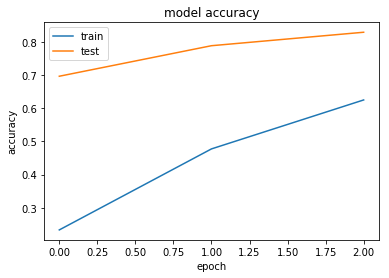

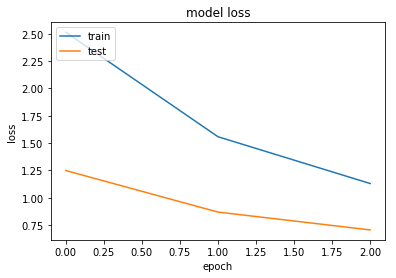

In [8]:
x_train = data_sets[0][0] # x_train
x_test = data_sets[0][1] # x_test
y_train = data_sets[0][2] # y_train
y_test = data_sets[0][3] # y_test
pre_data_train = data_sets[0][4] # pre_data_train
pre_data_test = data_sets[0][5] # pre_data_test

y_pred = model_train_evaluate(embeddings_index, x_train, y_train, x_test, y_test, pre_x_test, id2word)

In [9]:
error_data1 = generate_template(y_test.argmax(-1), y_pred.argmax(-1), pre_data_test, labelEncoder)
print ("error data has {} rows".format(len(error_data1)))
print (error_data1.head(10))

(2464, 7)
error data has 488 rows
               category  char_length    idx  \
0        EN_US_BUSINESS       3804.0  10425   
5       EN_US_LIFESTYLE       3225.0  13472   
13      EN_US_LIFESTYLE       4856.0   6882   
21       EN_US_NATIONAL       4019.0   4938   
27      EN_US_LIFESTYLE       1864.0     44   
28      EN_US_LIFESTYLE       6950.0   4735   
33       EN_US_BUSINESS      16542.0  10519   
41  EN_US_ENTERTAINMENT       4546.0   2931   
49       EN_US_POLITICS       3529.0  11793   
56      EN_US_LIFESTYLE       7600.0   7090   

                                                 text  \
0   [article_title] [article_body] Want To Work Fo...   
5   The very hungry caterpillars: Amazing pictures...   
13  Katie Heaney BuzzFeed Staff colematt / Thinkst...   
21  Health-care fraud in America That’s where the ...   
27  News A A A (resize font) (CNN) - Here's a roun...   
28  Your brain's system for directing attention is...   
33  News Entertainment Lifestyle Tech & Innovatio

/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Train on 6651 samples, validate on 740 samples
Epoch 1/3
6651/6651 [==============================] - 56s 8ms/step - loss: 2.5039 - acc: 0.2330 - val_loss: 1.2473 - val_acc: 0.7068
Epoch 2/3
6651/6651 [==============================] - 71s 11ms/step - loss: 1.5983 - acc: 0.4638 - val_loss: 0.8801 - val_acc: 0.7770
Epoch 3/3
6651/6651 [==============================] - 70s 11ms/step - loss: 1.1362 - acc: 0.6190 - val_loss: 0.7098 - val_acc: 0.8230
acc: 78.90%
---------Confusion Matrix Report -------------------- 

[[105   5  11   8   9   5  10  39  14]
 [  1 242   5   8   2   6  19   9   5]
 [  2  31 103  15   4  18  10  15   9]
 [  4   3   9 174  16   9   9   4   8]
 [  4   2   4   6 240   0   5   3  25]
 [  1   2   2   0   2 256   6   8   4]
 [  0   6   1   0   1   2 372   3   2]
 [  8   4   9   1   1  12   3 249   5]
 [  9  10   2  16  10   8   7   4 203]]

---------Classificaiton Report ---------------------- 

             precision    recall  f1-score   support

          0       

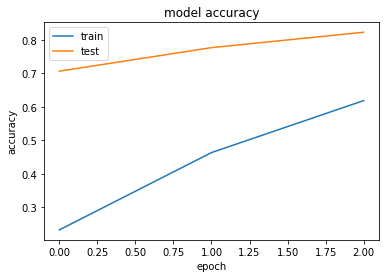

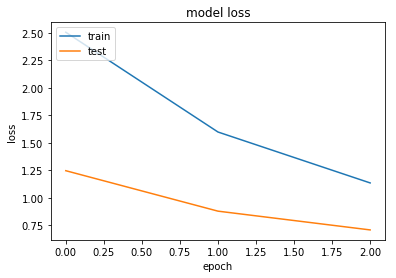

In [10]:
x_train = data_sets[1][0] # x_train
x_test = data_sets[1][1] # x_test
y_train = data_sets[1][2] # y_train
y_test = data_sets[1][3] # y_test
pre_data_train = data_sets[1][4] # pre_data_train
pre_data_test = data_sets[1][5] # pre_data_test

y_pred = model_train_evaluate(embeddings_index, x_train, y_train, x_test, y_test, pre_x_test, id2word)

In [11]:
error_data2 = generate_template(y_test.argmax(-1), y_pred.argmax(-1), pre_data_test, labelEncoder)
print ("error data has {} rows".format(len(error_data2)))
print (error_data2.head(10))

(2464, 7)
error data has 520 rows
              category  char_length    idx  \
2469    EN_US_BUSINESS      11655.0   7836   
2473   EN_US_LIFESTYLE       1822.0   1725   
2483      EN_US_SPORTS       1078.0    245   
2504   EN_US_LIFESTYLE      10090.0   6772   
2510    EN_US_BUSINESS       7520.0   9161   
2517   EN_US_LIFESTYLE       3513.0   5375   
2521    EN_US_POLITICS       2121.0  14931   
2528    EN_US_BUSINESS       9061.0    691   
2543  EN_US_TECHNOLOGY       9810.0  14888   
2544    EN_US_BUSINESS       4396.0   1669   

                                                   text  \
2469  A big screen flashes commercials on the exteri...   
2473  Senior dog heartbroken after owner surrendered...   
2483  iPlayer Radio After reliving Muhammad Ali's fa...   
2504  A wedding cake depicting a same-sex couple. Si...   
2510  Ford has taken a big gamble with its all-alumi...   
2517  Speed volunteering will link people to relevan...   
2521  US Secretary of State John Kerry has met

Train on 6651 samples, validate on 740 samples
Epoch 1/3
6651/6651 [==============================] - 71s 11ms/step - loss: 2.5480 - acc: 0.2324 - val_loss: 1.2828 - val_acc: 0.6514
Epoch 2/3
6651/6651 [==============================] - 70s 11ms/step - loss: 1.6082 - acc: 0.4563 - val_loss: 0.8455 - val_acc: 0.8270
Epoch 3/3
6651/6651 [==============================] - 70s 11ms/step - loss: 1.1526 - acc: 0.6149 - val_loss: 0.6890 - val_acc: 0.8324
acc: 80.97%
---------Confusion Matrix Report -------------------- 

[[117   2  18   6   6   3   6  38  15]
 [  0 262   9   4   3   1   6  10   2]
 [  3  21 112  11   6  18   4   6  13]
 [  3   8   6 167  15  11   4   4   9]
 [  1   3   3   9 246   1   1   3  24]
 [  1   4  10   3   2 275   2   5   3]
 [  2   1   1   2   1   1 329   2   1]
 [  6   4  10   1   1  15   0 244   6]
 [  5   3   8  19   4  12   9   9 243]]

---------Classificaiton Report ---------------------- 

             precision    recall  f1-score   support

          0      

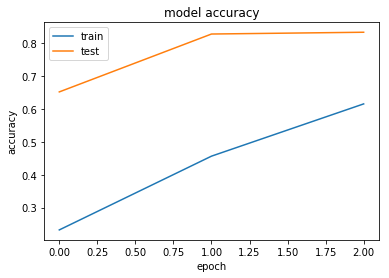

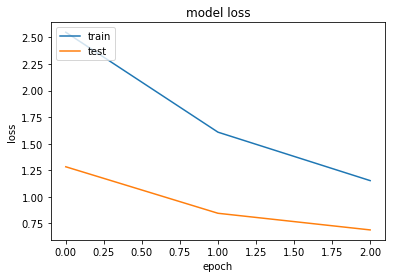

(2464, 7)
error data has 469 rows
                 category  char_length    idx  \
4930       EN_US_POLITICS       4428.0  21897   
4936          EN_US_WORLD       8617.0   1865   
4937          EN_US_WORLD       1595.0   1362   
4946       EN_US_NATIONAL       9131.0  19607   
4950       EN_US_BUSINESS       8144.0   9036   
4962  EN_US_ENTERTAINMENT       2831.0   4416   
4967       EN_US_BUSINESS       4091.0   9372   
4970       EN_US_BUSINESS       4269.0  11474   
4984       EN_US_NATIONAL       8502.0   8940   
4987       EN_US_POLITICS       5876.0  12159   

                                                   text  \
4930  1. Pauline Pearce, dubbed the Hackney Heroine ...   
4936  Story by the Associated Press; curated by Dave...   
4937  Japanese teenager straps toothbrush to an auto...   
4946  In his brief remarks Thursday on the alarming ...   
4950  Once I was making oatmeal in the microwave in ...   
4962  Money LIFE Photography Videos Next Generation ...   
4967  The wor

In [12]:
x_train = data_sets[2][0] # x_train
x_test = data_sets[2][1] # x_test
y_train = data_sets[2][2] # y_train
y_test = data_sets[2][3] # y_test
pre_data_train = data_sets[2][4] # pre_data_train
pre_data_test = data_sets[2][5] # pre_data_test

y_pred = model_train_evaluate(embeddings_index, x_train, y_train, x_test, y_test, pre_x_test, id2word)
error_data3 = generate_template(y_test.argmax(-1), y_pred.argmax(-1), pre_data_test, labelEncoder)
print ("error data has {} rows".format(len(error_data3)))
print (error_data3.head(10))

Train on 6652 samples, validate on 740 samples
Epoch 1/3
6652/6652 [==============================] - 71s 11ms/step - loss: 2.5275 - acc: 0.2387 - val_loss: 1.2044 - val_acc: 0.7297
Epoch 2/3
6652/6652 [==============================] - 73s 11ms/step - loss: 1.5938 - acc: 0.4642 - val_loss: 0.8356 - val_acc: 0.7986
Epoch 3/3
6652/6652 [==============================] - 80s 12ms/step - loss: 1.1859 - acc: 0.6022 - val_loss: 0.6791 - val_acc: 0.8189
acc: 82.58%
---------Confusion Matrix Report -------------------- 

[[124   8   9   4   7   5   2  19  11]
 [  1 274   8   9   1   0   6   6   3]
 [  4  37  96  15   7  11   7  11   2]
 [  3   5   3 184  19   7   5   3  15]
 [  0   5   3   9 257   1   1   1  11]
 [  2   7   6   7   2 282   0   6   6]
 [  0   5   2   3   2   0 336   4   2]
 [  5   3   6   3   0   3   2 256   6]
 [  5  11   6  11  13   6   6   5 225]]

---------Classificaiton Report ---------------------- 

             precision    recall  f1-score   support

          0      

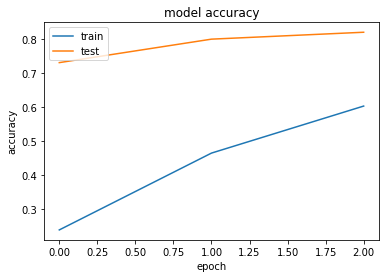

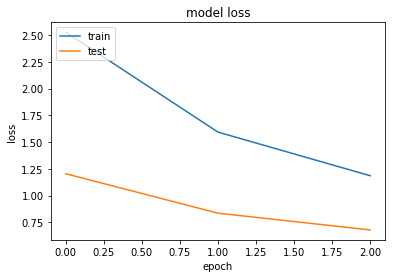

(2463, 7)
error data has 429 rows
                 category  char_length    idx  \
7392          EN_US_WORLD       6372.0   3637   
7395      EN_US_LIFESTYLE       1349.0  55692   
7396     EN_US_TECHNOLOGY       2726.0   7617   
7399      EN_US_LIFESTYLE      11470.0   6592   
7400        EN_US_SCIENCE       6164.0  23754   
7407       EN_US_NATIONAL      14289.0   3914   
7410  EN_US_ENTERTAINMENT       7056.0   5682   
7415       EN_US_BUSINESS       5352.0  11679   
7417       EN_US_POLITICS       4255.0   8197   
7420       EN_US_NATIONAL       2103.0  14184   

                                                   text  \
7392  So much for summer: Snow set to blast Scotland...   
7395  More iPlayer Radio The BBC's economic editor R...   
7396  GE, the world's sixth-largest company, reveals...   
7399  Igor Bobic The Huffington Post 06/10/14 10:39 ...   
7400  White rhinos in Nakuru Africa Three students f...   
7407  News Entertainment Lifestyle Tech & Innovation...   
7410  At leas

In [13]:
x_train = data_sets[3][0] # x_train
x_test = data_sets[3][1] # x_test
y_train = data_sets[3][2] # y_train
y_test = data_sets[3][3] # y_test
pre_data_train = data_sets[3][4] # pre_data_train
pre_data_test = data_sets[3][5] # pre_data_test

y_pred = model_train_evaluate(embeddings_index, x_train, y_train, x_test, y_test, pre_x_test, id2word)
error_data4 = generate_template(y_test.argmax(-1), y_pred.argmax(-1), pre_data_test, labelEncoder)
print ("error data has {} rows".format(len(error_data4)))
print (error_data4.head(10))

In [14]:
error_combined = pd.concat([error_data1, error_data2, error_data3, error_data4])

error_combined.loc[:, ('idx','title', 'text', 'url', 'Test_label', 'Predict_label')].to_csv('error_combined.csv', sep=',', index = False)
print (error_combined.shape)

# make sure there is no duplicate row
error_combined.drop_duplicates(subset=['idx', 'title'], inplace = True)
print (error_combined.shape)

(1906, 9)
(1906, 9)


In [15]:
from io import StringIO
import boto3

def upload_to_s3(bucket, folder, file):
    s3 = boto3.resource('s3')
    data = open(file, "rb")
    key = 'tmp/data/classification/' + folder + file
    s3.Bucket(bucket).put_object(Key=key, Body=data)

bucket = 'smart-newsdev-dmp'
folder = 'data_handlabeling_cycle2/'

upload_to_s3(bucket, folder, 'error_combined.csv')